In [1]:
from astropy.table import Table, vstack
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
import os
from astropy.stats import sigma_clipped_stats
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
#from astropy.modeling.models import Schechter1D
import astropy.constants as ac
import pandas as pd
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import matplotlib.ticker as ticker

In [2]:
from matplotlib import rc                # Establece parámetros iniciales al grupo
rc('text', usetex=False)
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25
plt.rc('font', family='serif')
plt.rc('font', size=SMALL_SIZE)          # Controla tamaño de texto por defecto
plt.rc('axes', titlesize=BIGGER_SIZE)    # Tamaño de las fuentes de los títulos
# Tamaño de las fuentes de los ejes x e y
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)    # Tamaño de los tick en el eje x
plt.rc('ytick', labelsize=SMALL_SIZE)    # Tamaño de los tick en el eje y
plt.rc('legend', fontsize=SMALL_SIZE)    # Tamaño de las leyendas
# Tamaño de la fuente del título de la figura
plt.rc('figure', titlesize=BIGGER_SIZE)

In [3]:
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3) # Create a universe model

In [4]:
def abmag(mag):
    flux = 3631 * 10**(-0.4*mag)
    return flux

In [5]:
def volume_redshift(z, area):
    
    err = 0.01
    zmin = z-err
    zmax = z+err
    "Obstains the volume given a minimum and maximum redshift, using the cosmology comoving distance"
    D_min = cosmo.luminosity_distance(zmin)
    D_max = cosmo.luminosity_distance(zmax)

    #else:
    volume_min = (4/3 * np.pi * (D_min ** 3))/(1+zmin)**3
    volume_max = (4/3 * np.pi * (D_max ** 3))/(1+zmax)**3
    volume =  (volume_max - volume_min)/(4*np.pi)*area*(np.pi/180)**2
    #
    #volume = cosmo.comoving_volume(zmax) - cosmo.comoving_volume(zmin)
    radianes = (area * (np.pi / 180)**2)
    #volume = (cosmo.comoving_volume(z+err) - cosmo.comoving_volume(z-err))*(radianes/4*np.pi)
    return volume.value 

In [6]:
def flux_lum(z, mag):
    flux = abmag(mag)
    # Convert from F_nu to F_lambda
    f_lam = []
    for f, f_nu in enumerate(flux):
        wavelength = 9640*u.AA #AA
        c_s = ac.c.to(u.AA/u.s)
        f_n = (92*f_nu*u.Jy).to(u.erg/u.s/u.cm**2/u.Hz)
        f_lambda = ((c_s / wavelength**2) * f_n)
        f_lam.append(f_lambda.value)
        #print(f_lambda) #erg / (Angstrom cm2 Hz s2)
    
    f_lam = np.array(f_lam)
    f_lam = f_lam*u.erg/u.cm**2/u.s
    phi = []
    lum = []
    lum_log = []
    for j, flux_ in enumerate(f_lam):

        D = cosmo.luminosity_distance(z)
        d_cm = D.to(u.cm)
        L = (flux_)*(4*np.pi*(d_cm**2))
        lum.append(L.value)
        lum_log.append(np.log10(L.value))
    
    lum = np.array([lum])
    lum_log = np.array(lum_log)

    
    return lum_log, lum, f_lam.value

In [7]:
table = Table.read('NSF1_Bagpipes_NO_AGN.fits')

In [8]:
def sch(phis, L, Ls, alpha):
    phi = phis * np.log(10) * (L/Ls)**(1+alpha)*np.exp(-L/Ls)
    return phi

In [9]:
mask1 =  (0 < table['redshift_50']) & (table['redshift_50'] < 0.7)

data_a =table[mask1]

In [10]:
mask2 =  (0.7 < table['redshift_50']) & (table['redshift_50'] < 1.3)

data_b = table[mask2]

In [11]:
mask3 =  (1.3 < table['redshift_50']) & (table['redshift_50'] < 2)
data_c = table[mask3]

In [12]:
al = np.mean(data_a['redshift_50']-data_a['redshift_16'])
ah = np.mean(data_a['redshift_84']-data_a['redshift_50'])
bl = np.mean(data_b['redshift_50']-data_b['redshift_16'])
bh = np.mean(data_b['redshift_84']-data_b['redshift_50'])
cl = np.mean(data_c['redshift_50']-data_c['redshift_16'])
ch = np.mean(data_c['redshift_84']-data_c['redshift_50'])

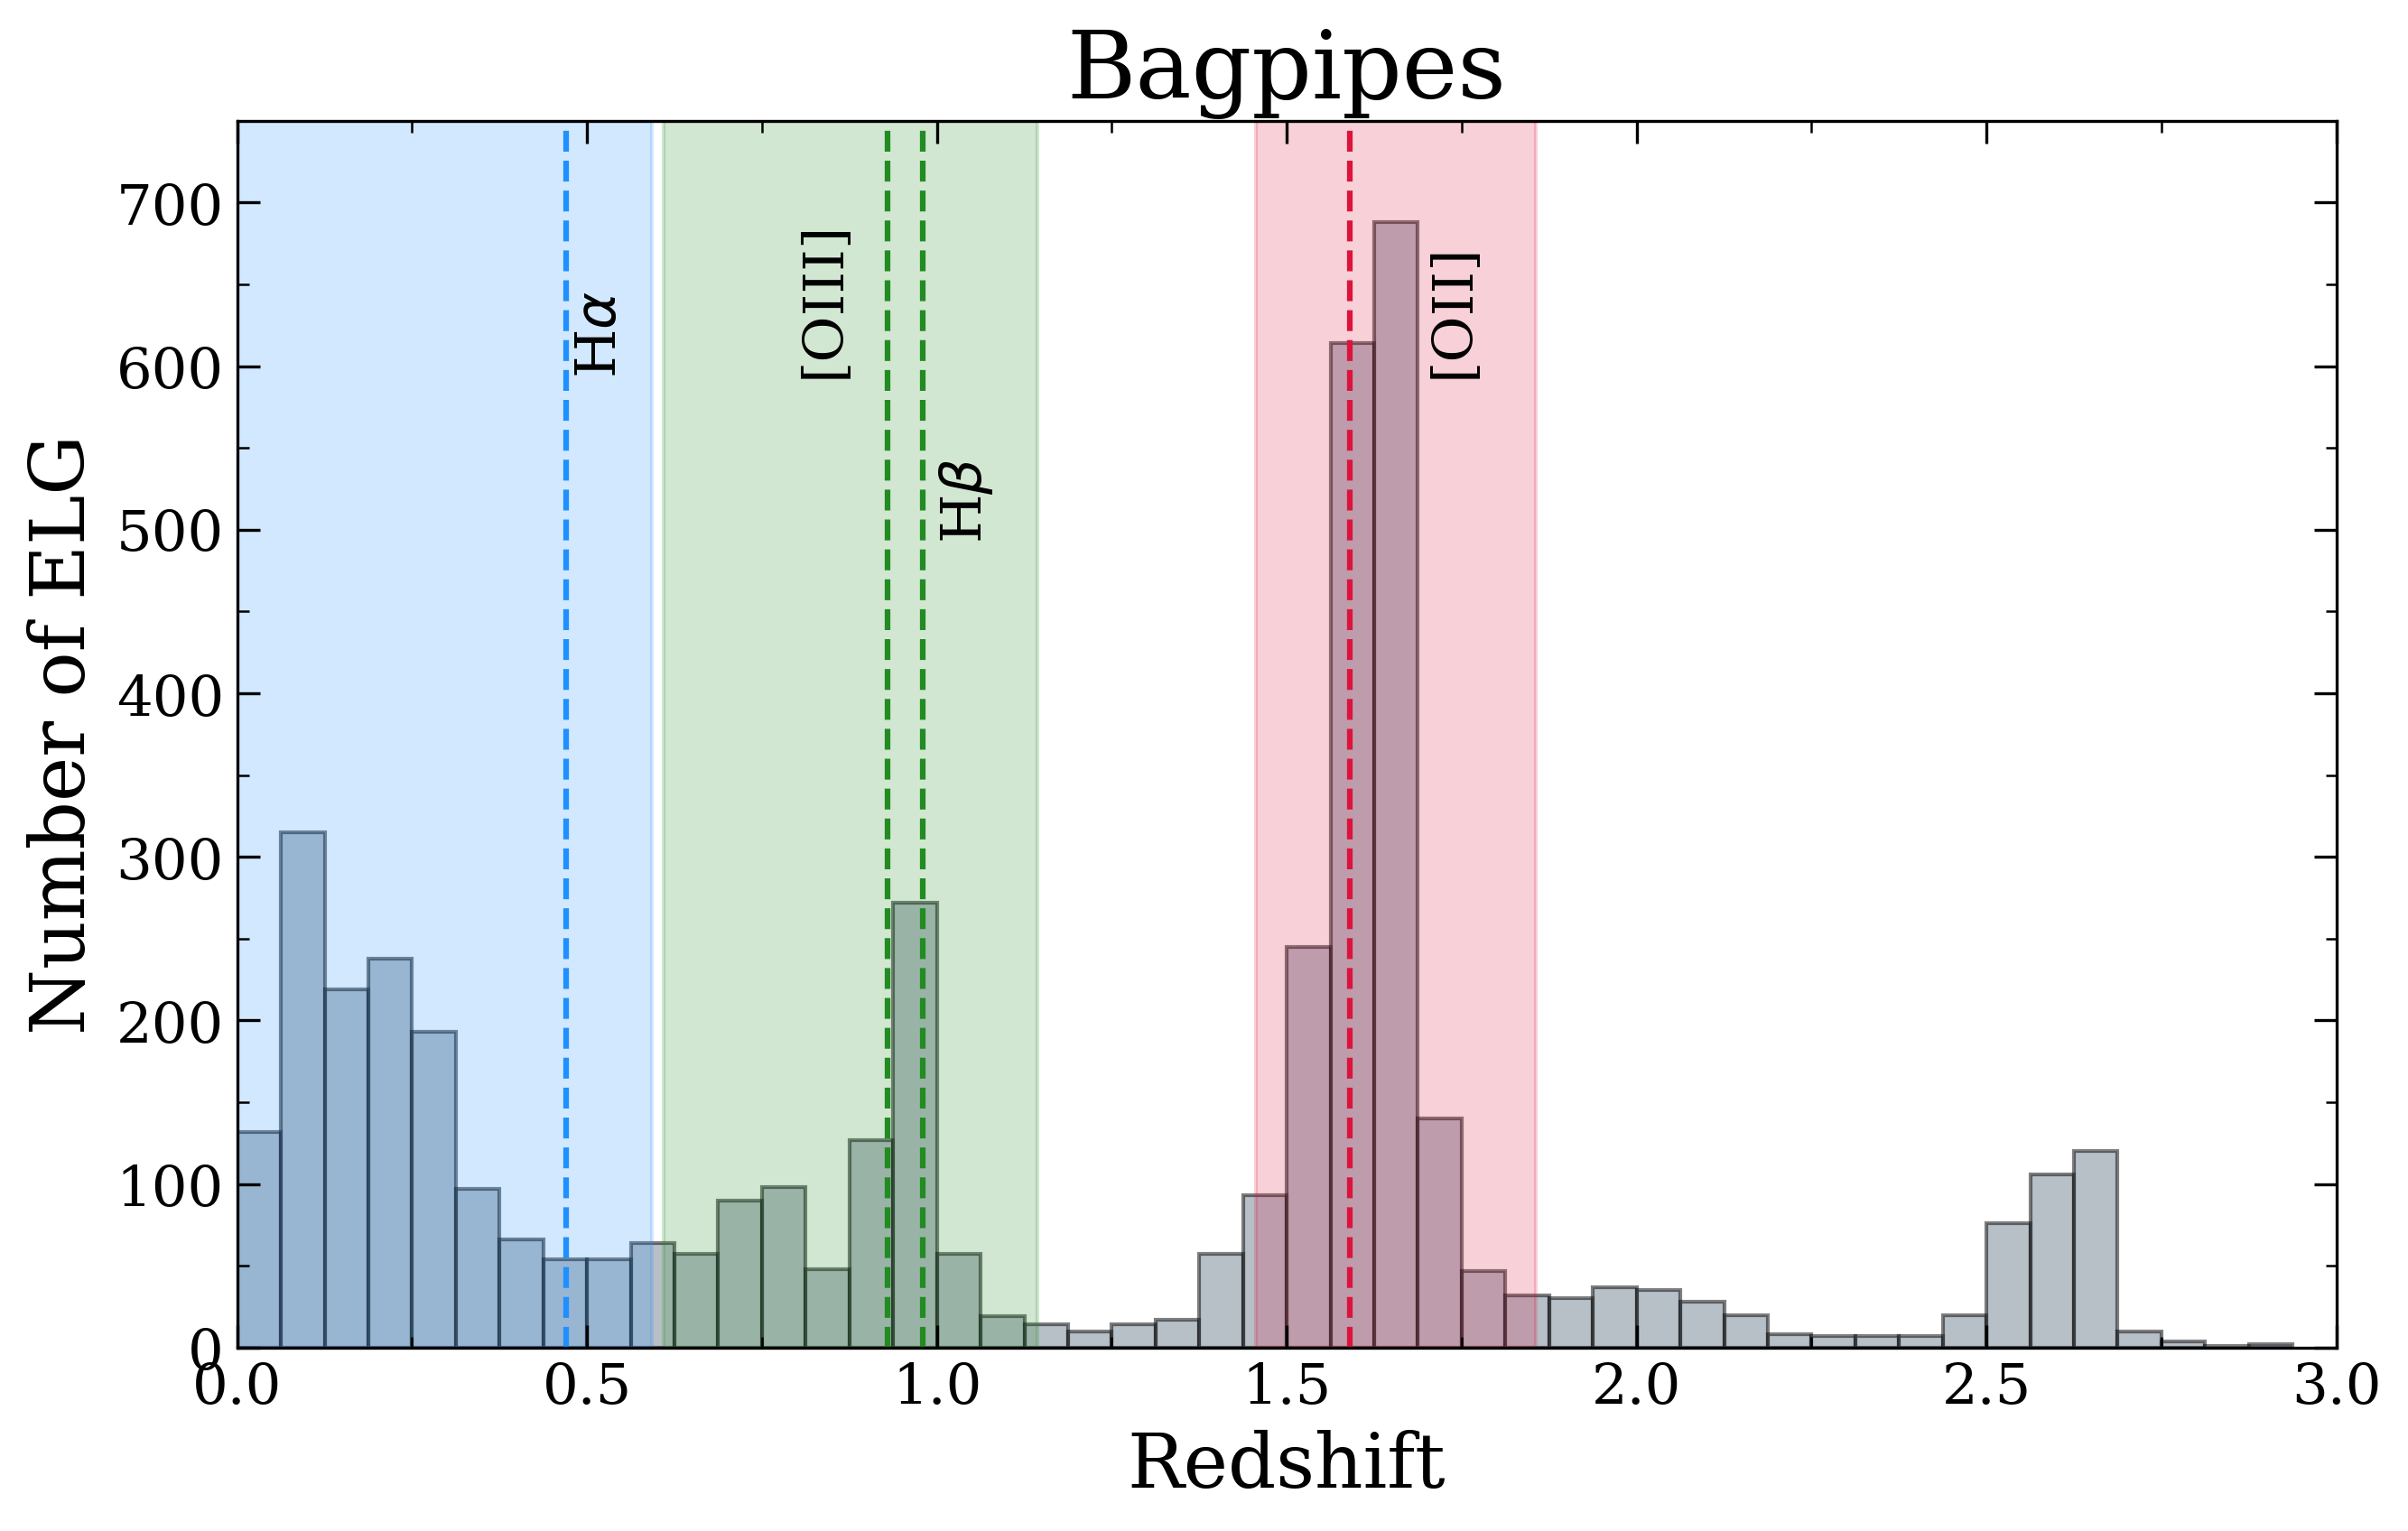

In [13]:
fig,ax=plt.subplots(figsize=(10,6), dpi=300)

bins = np.arange(0,3,0.0625)


ax.hist(table['redshift_50'], bins =bins, histtype ='bar', alpha = 0.5, 
         color = 'slategray',ec = 'k')
ax.vlines(0.47,0,1000, linestyle ='dashed', color = 'dodgerblue')
ax.axvspan(0.47-ah, 0.47+al, alpha=0.2, color='dodgerblue')
ax.text(0.48, 600, r'H$\alpha$', size = 15, rotation='vertical')

ax.vlines(0.98,0,1000, linestyle ='dashed', color = 'forestgreen')
#ax.axvspan(0.86,1.05, alpha=0.2, color='forestgreen')
ax.text(1, 500, r'H$\beta$', size = 15, rotation='vertical')

ax.vlines(0.93,0,1000, linestyle ='dashed', color = 'forestgreen')
ax.axvspan(0.93-bh, 0.93+bl, alpha=0.2, color='forestgreen')
ax.text(0.8, 600, r'[OIII]', size = 15, rotation='vertical')

ax.vlines(1.59,0,1000, linestyle ='dashed', color = 'crimson')
ax.axvspan(1.59-ch, 1.59+cl, alpha=0.2, color='crimson')
ax.text(1.7, 600, r'[OII]', size = 15, rotation='vertical')

# ax.vlines(2.44,0,1000, linestyle ='dashed', color = 'crimson')
# ax.axvspan(1.30, 1.9, alpha=0.2, color='crimson')
# ax.text(2.5, 650, r'MgII', size = 15, rotation='vertical')
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))      # Ticks principales cada 1 unidades en el eje x
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))    # Ticks secundarios cada 0.1 unidades en el eje x
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))      # Ticks principales cada 1 unidades en el eje y
ax.yaxis.set_minor_locator(ticker.MultipleLocator(50))    # Ticks secundarios cada 0.5 unidades en el eje y
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', length=6)   # Ticks en el eje x en la parte inferior y superior
ax.tick_params(axis='x', which='minor', bottom=True, top=True, direction='in', length=3)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', length=6)   # Ticks en el eje y en el lado izquierdo y derecho
ax.tick_params(axis='y', which='minor', bottom=True, top=True, direction='in', length=3)
#plt.vlines(0.2,0,1000, linestyle ='dashed', color = 'crimson')
ax.set_xlim(0,3)
ax.set_ylim(0,750)
ax.set_title('Bagpipes')
ax.set_xlabel('Redshift')
ax.set_ylabel('Number of ELG')
plt.show()

# H$\alpha$

In [14]:
# mask_H =  (0.47-ah < data_a['redshift_50']) & (data_a['redshift_50'] < 0.47+al)
# H_a = data_a[mask_H]

mask_H =  (0 < table['redshift_50']) & (table['redshift_50'] < 0.7)

H_a =table[mask_H]

In [15]:
phi_star = 10**(-3.16) #* (u.Mpc ** -3)
L_star = (10**(41.72))
alpha = -1.75

In [16]:
aper = 2
H_mag = np.array([H_a['MAG_APER_1'][i][aper] for i in range(len(H_a))])
l_H = flux_lum(0.47, H_mag)

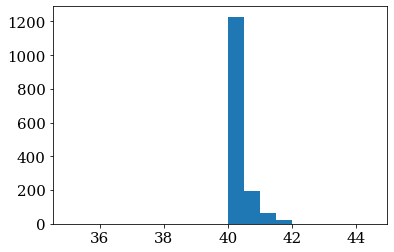

In [64]:
b = np.arange(35, 45,0.5)
alf_H, blf, clf =plt.hist(l_H[0], bins = b) #alf = objetos por bin
#plt.xlim(41,43.5)
plt.show()

In [65]:
bx_H = (b[0:-1]+b[1:])/2

binsize_H = bx_H[1]-bx_H[0]

lss_H = np.linspace(38,44,100)

In [66]:
vol_H = volume_redshift(0.47,2.94)

numb_ =  np.logspace((38),(44),100)
phia = sch(phi_star, numb_, L_star, alpha)

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


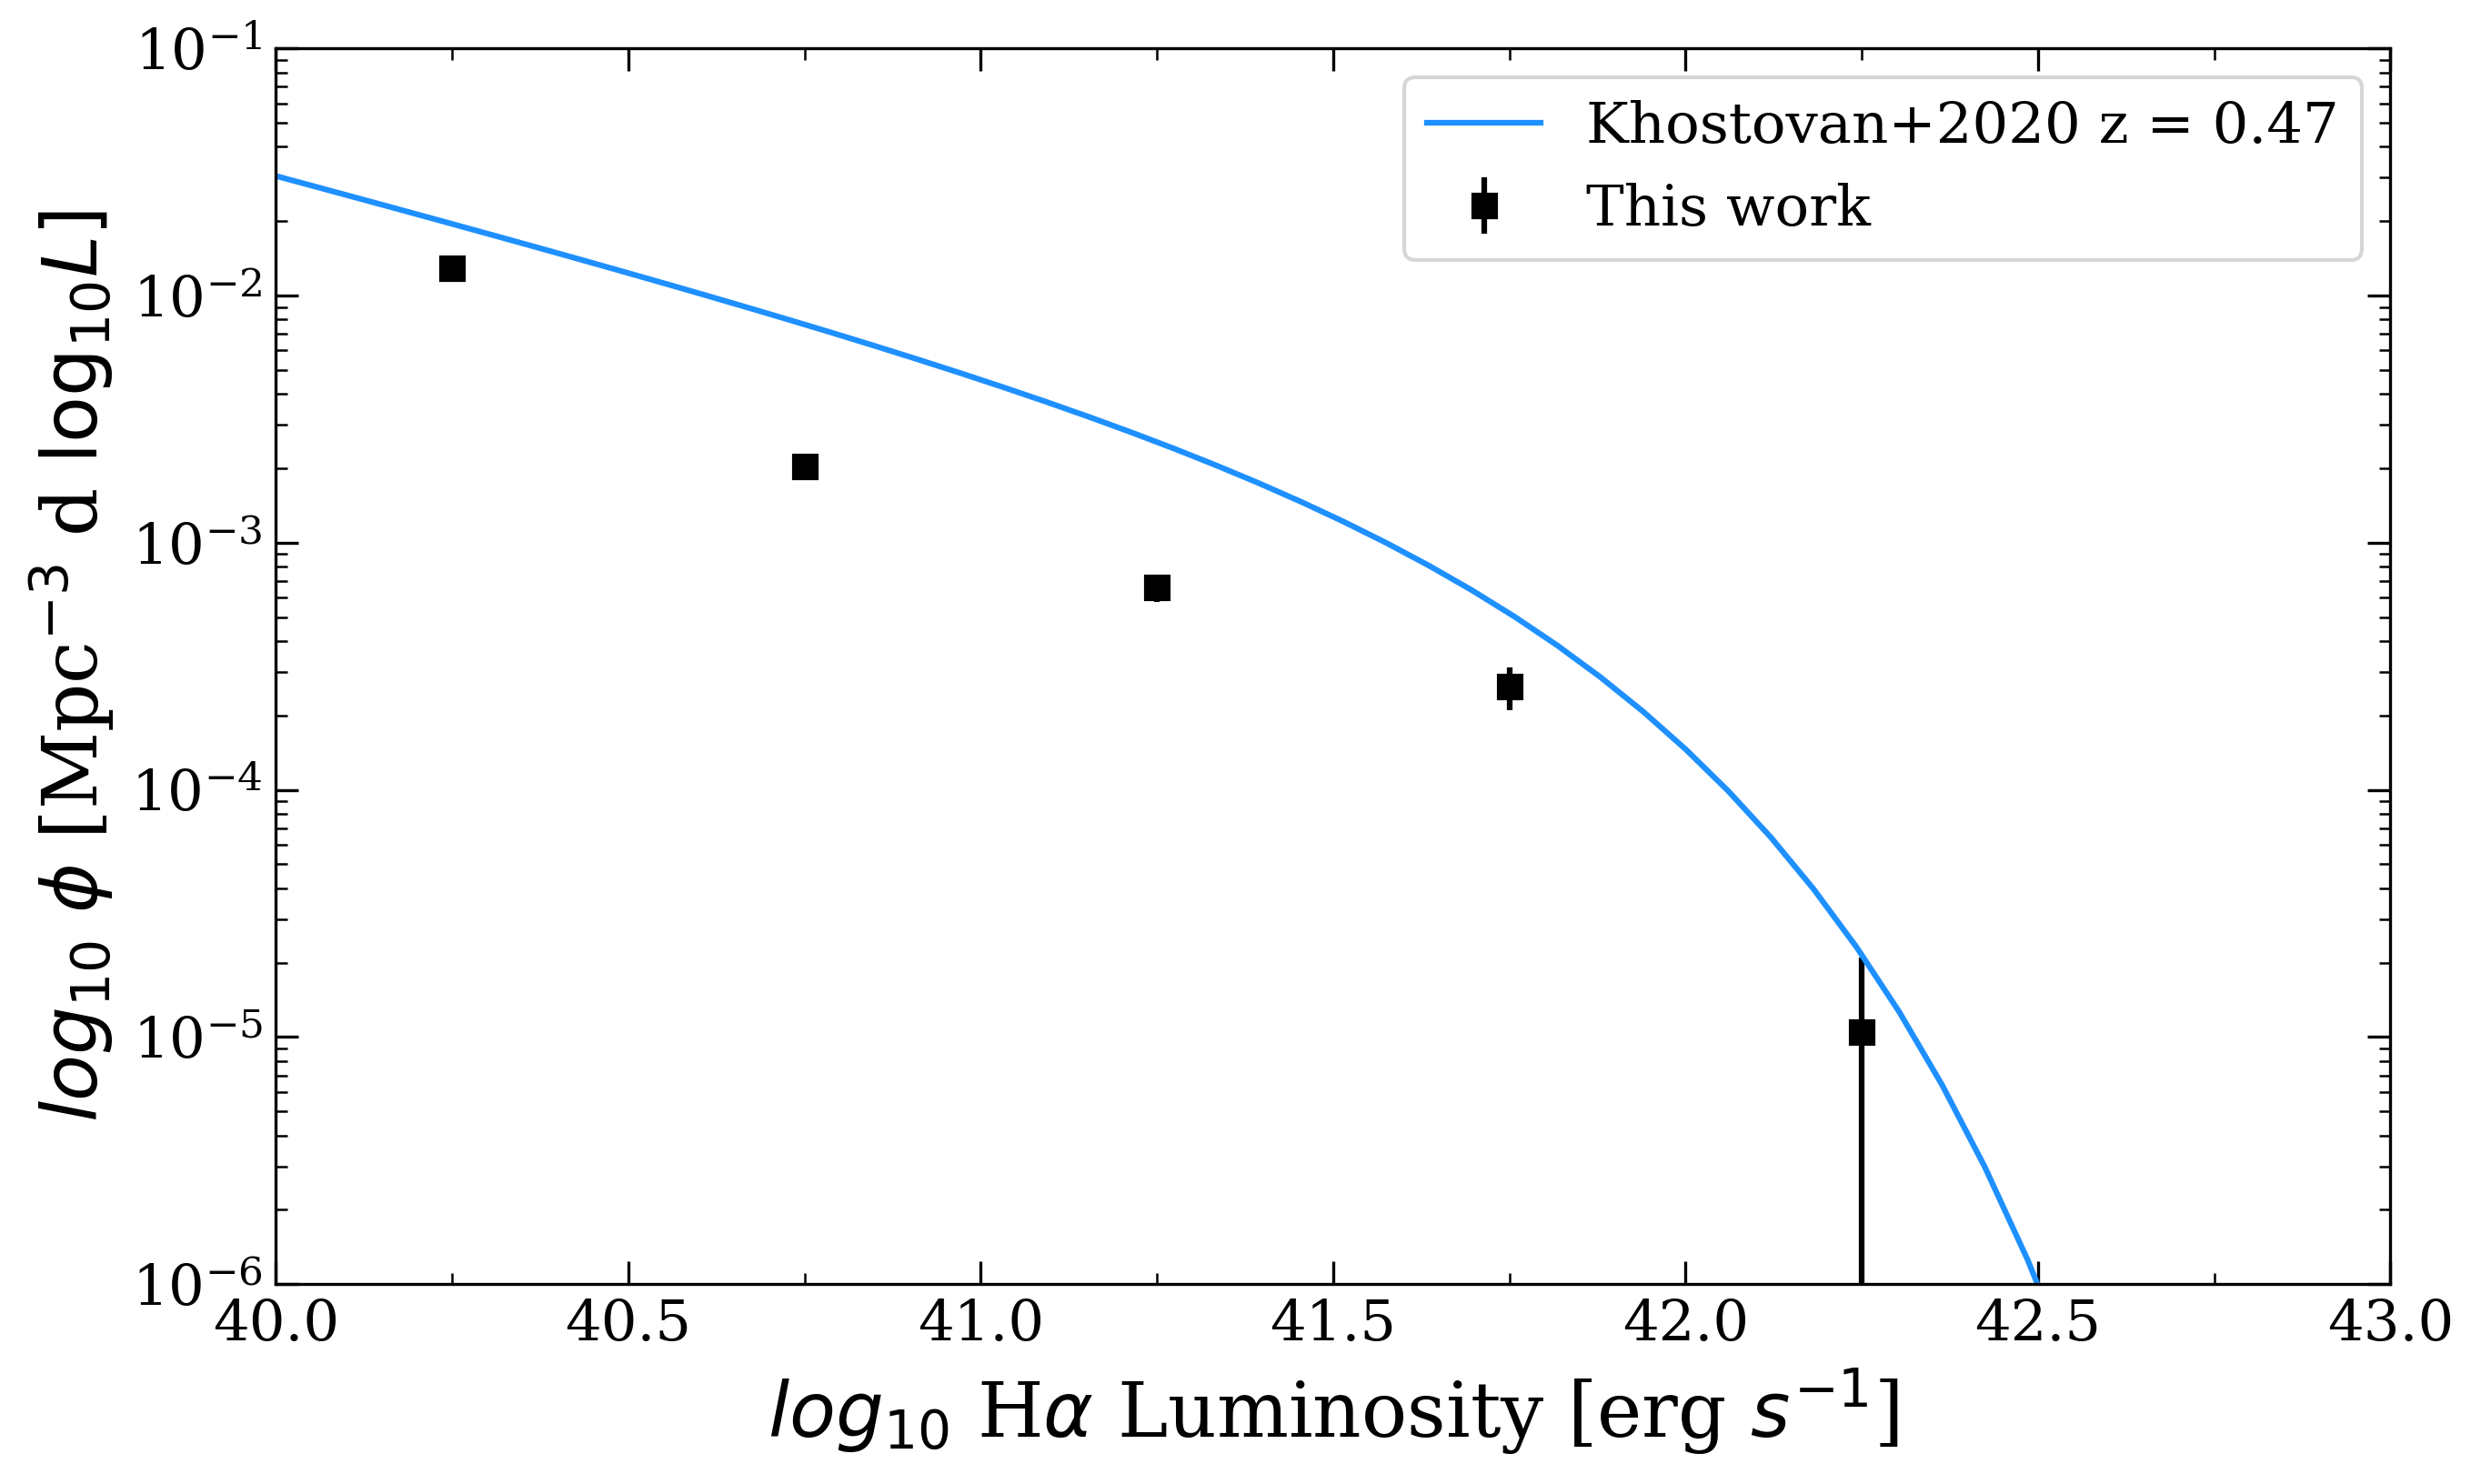

In [67]:
yy_H = alf_H/vol_H/binsize_H
err_H = 1/np.sqrt(alf_H)

fig, ax = plt.subplots(figsize=(10,6), dpi = 300)
plt.errorbar(bx_H,yy_H, yerr = yy_H*err_H, ls = 'none', marker = 's', color = 'k', label = 'This work')
ax.plot(lss_H, phia, color = 'dodgerblue', label = 'Khostovan+2020 z = 0.47')

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))      # Ticks principales cada 1 unidades en el eje x
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))    # Ticks secundarios cada 0.1 unidades en el eje x
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))      # Ticks principales cada 1 unidades en el eje y
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))    # Ticks secundarios cada 0.5 unidades en el eje y
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', length=6)   # Ticks en el eje x en la parte inferior y superior
ax.tick_params(axis='x', which='minor', bottom=True, top=True, direction='in', length=3)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', length=6)   # Ticks en el eje y en el lado izquierdo y derecho
ax.tick_params(axis='y', which='minor', left=True, right=True, direction='in', length=3)

plt.yscale('log')
plt.ylim(1e-6,1e-1)
plt.xlim(40,43)

plt.xlabel(r'$log_{10}$ H$\alpha$ Luminosity [erg $s^{-1}$]')
plt.ylabel(r'$log_{10}$ $\phi$ [Mpc$^{-3}$ d $\log_{10} L]$')
plt.legend()
plt.show()

In [68]:
mask = yy_H > 0
yy_H2 = yy_H[mask]
bx_H2 = bx_H[mask]
err_H2 = err_H[mask]

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


Model: schechter
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
             phis                    Ls                 alpha       
    ---------------------- --------------------- -------------------
    0.00011388878936875088 7.683410397669982e+41 -1.9583987741491482


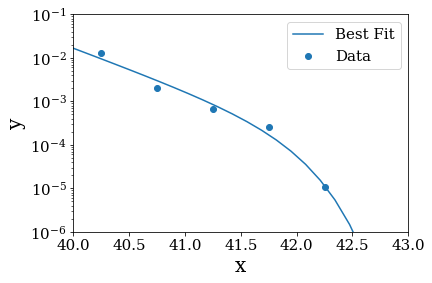

In [69]:
from astropy.modeling.models import custom_model
from astropy.modeling import models, fitting


@custom_model
def schechter(L, phis = phi_star, Ls = L_star, alpha = alpha):
    phi = phis * np.log(10) * (L/Ls)**(1+alpha)*np.exp(-L/Ls)
    return np.log10(phi)


model = schechter()
fitter = fitting.LevMarLSQFitter()
best_fit_mH = fitter(model, 10**bx_H2, np.log10(yy_H2))
print(best_fit_mH)

x_new = np.linspace(30, 43, 100)
y_new = best_fit_mH(10**x_new)
#plt.plot(lss_H, phia, color = 'dodgerblue', label = 'Khostovan+2020 z = 0.47')
plt.scatter(bx_H2, yy_H2, label='Data')
plt.plot(x_new, 10**y_new, label='Best Fit')
plt.legend()
plt.yscale('log')
plt.xlim(40,43)
plt.ylim(1e-6,1e-1)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarnin

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarni

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarnin

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarni

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarn

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarni

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarni

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarnin

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarn

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarni

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarn

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: Run

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarn

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarni

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: Run

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWar

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarnin

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarn

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWar

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarn

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarnin

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarn

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


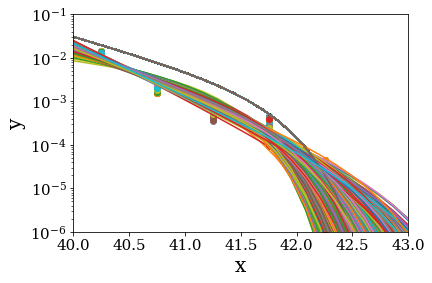

CPU times: user 1min, sys: 3.01 s, total: 1min 3s
Wall time: 59.1 s


In [23]:
%%time
results = []
iterations = 2000
while len(results) < iterations:
    values_y = []
    for i, bins in enumerate(yy_H2): 
        s = np.random.normal(bins, bins*err_H2[i],1)
        values_y.append(s[0])
        
    
    values_y = np.array(values_y)

    model = schechter()
    fitter = fitting.LevMarLSQFitter()
    best_fit = fitter(model, 10**bx_H2, np.log10(values_y))
    results.append((best_fit.phis.value, best_fit.Ls.value, best_fit.alpha.value))

    x_new = np.linspace(30, 43, 100)
    y_new = best_fit(10**x_new)
    plt.scatter(bx_H2, values_y)
    plt.plot(x_new, 10**y_new)
    plt.yscale('log')
    plt.xlim(40,43)
    plt.ylim(1e-6,1e-1)
    plt.xlabel('x')
    plt.ylabel('y')
plt.show()

results = np.array(results)

In [24]:
res_phi = np.array([results[i][0] for i in range(len(results))])
res_Ls = np.array([results[i][1] for i in range(len(results))])
res_alpha = np.array([results[i][2] for i in range(len(results))])

phi_scs =sigma_clipped_stats(res_phi)
Ls_scs = sigma_clipped_stats(res_Ls)
alpha_scs = sigma_clipped_stats(res_alpha)

phisH = (best_fit_mH.phis.value)
errphil =((phi_scs[1]-phi_scs[2]))
errphih = ((phi_scs[1]+phi_scs[2]))

LsH =((best_fit_mH.Ls.value))
errLsl =((Ls_scs[1]-Ls_scs[2]))
errLsh =((Ls_scs[1]+Ls_scs[2]))

alphaH =(best_fit_mH.alpha.value)
erralphah = ((alpha_scs[1]-alpha_scs[2]))
erralphal =((alpha_scs[1]+alpha_scs[2]))

In [25]:
print('Erros for Phi:')
print(np.log10(best_fit_mH.phis.value))
print(np.log10(phi_scs[1])-np.log10(phi_scs[1]-phi_scs[2]))
print(np.log10(phi_scs[1])-np.log10(phi_scs[1]+phi_scs[2]))
print('Erros for Ls:')
print(np.log10(best_fit_mH.Ls.value))
print(np.log10(Ls_scs[1])-np.log10(Ls_scs[1]-Ls_scs[2]))
print(np.log10(Ls_scs[1])-np.log10(Ls_scs[1]+Ls_scs[2]))
print('Erros for alpha:')
print(best_fit_mH.alpha.value)
print((alpha_scs[1])-(alpha_scs[1]-alpha_scs[2]))
print((alpha_scs[1])-(alpha_scs[1]+alpha_scs[2]))

Erros for Phi:
-3.943519023549592
nan
-0.48458981888888664
Erros for Ls:
41.88555403098626
0.3076682675321507
-0.17828165795320672
Erros for alpha:
-1.9583987741491482
0.13808700864739443
-0.13808700864739465


/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
phi_scs[2]-0.0001

0.00014117961769017815

In [92]:
#STROE SOBRAL HA z = 2
phi_SS = sch(10**(-2.85), numb_, 10**(41.75),-1.7)
#HAYASHI 2018
phi_Ha = sch(10**(-3.45), numb_, 10**(41.86), -1.75)
#LY 2007
phi_Ly = sch(10**(-2.4), numb_, 10**(41.29), -1.28)
#Sobral Z = 0.4
phi_SO = sch(10**(-3.12), numb_, 10**(41.95),-1.75)


/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.


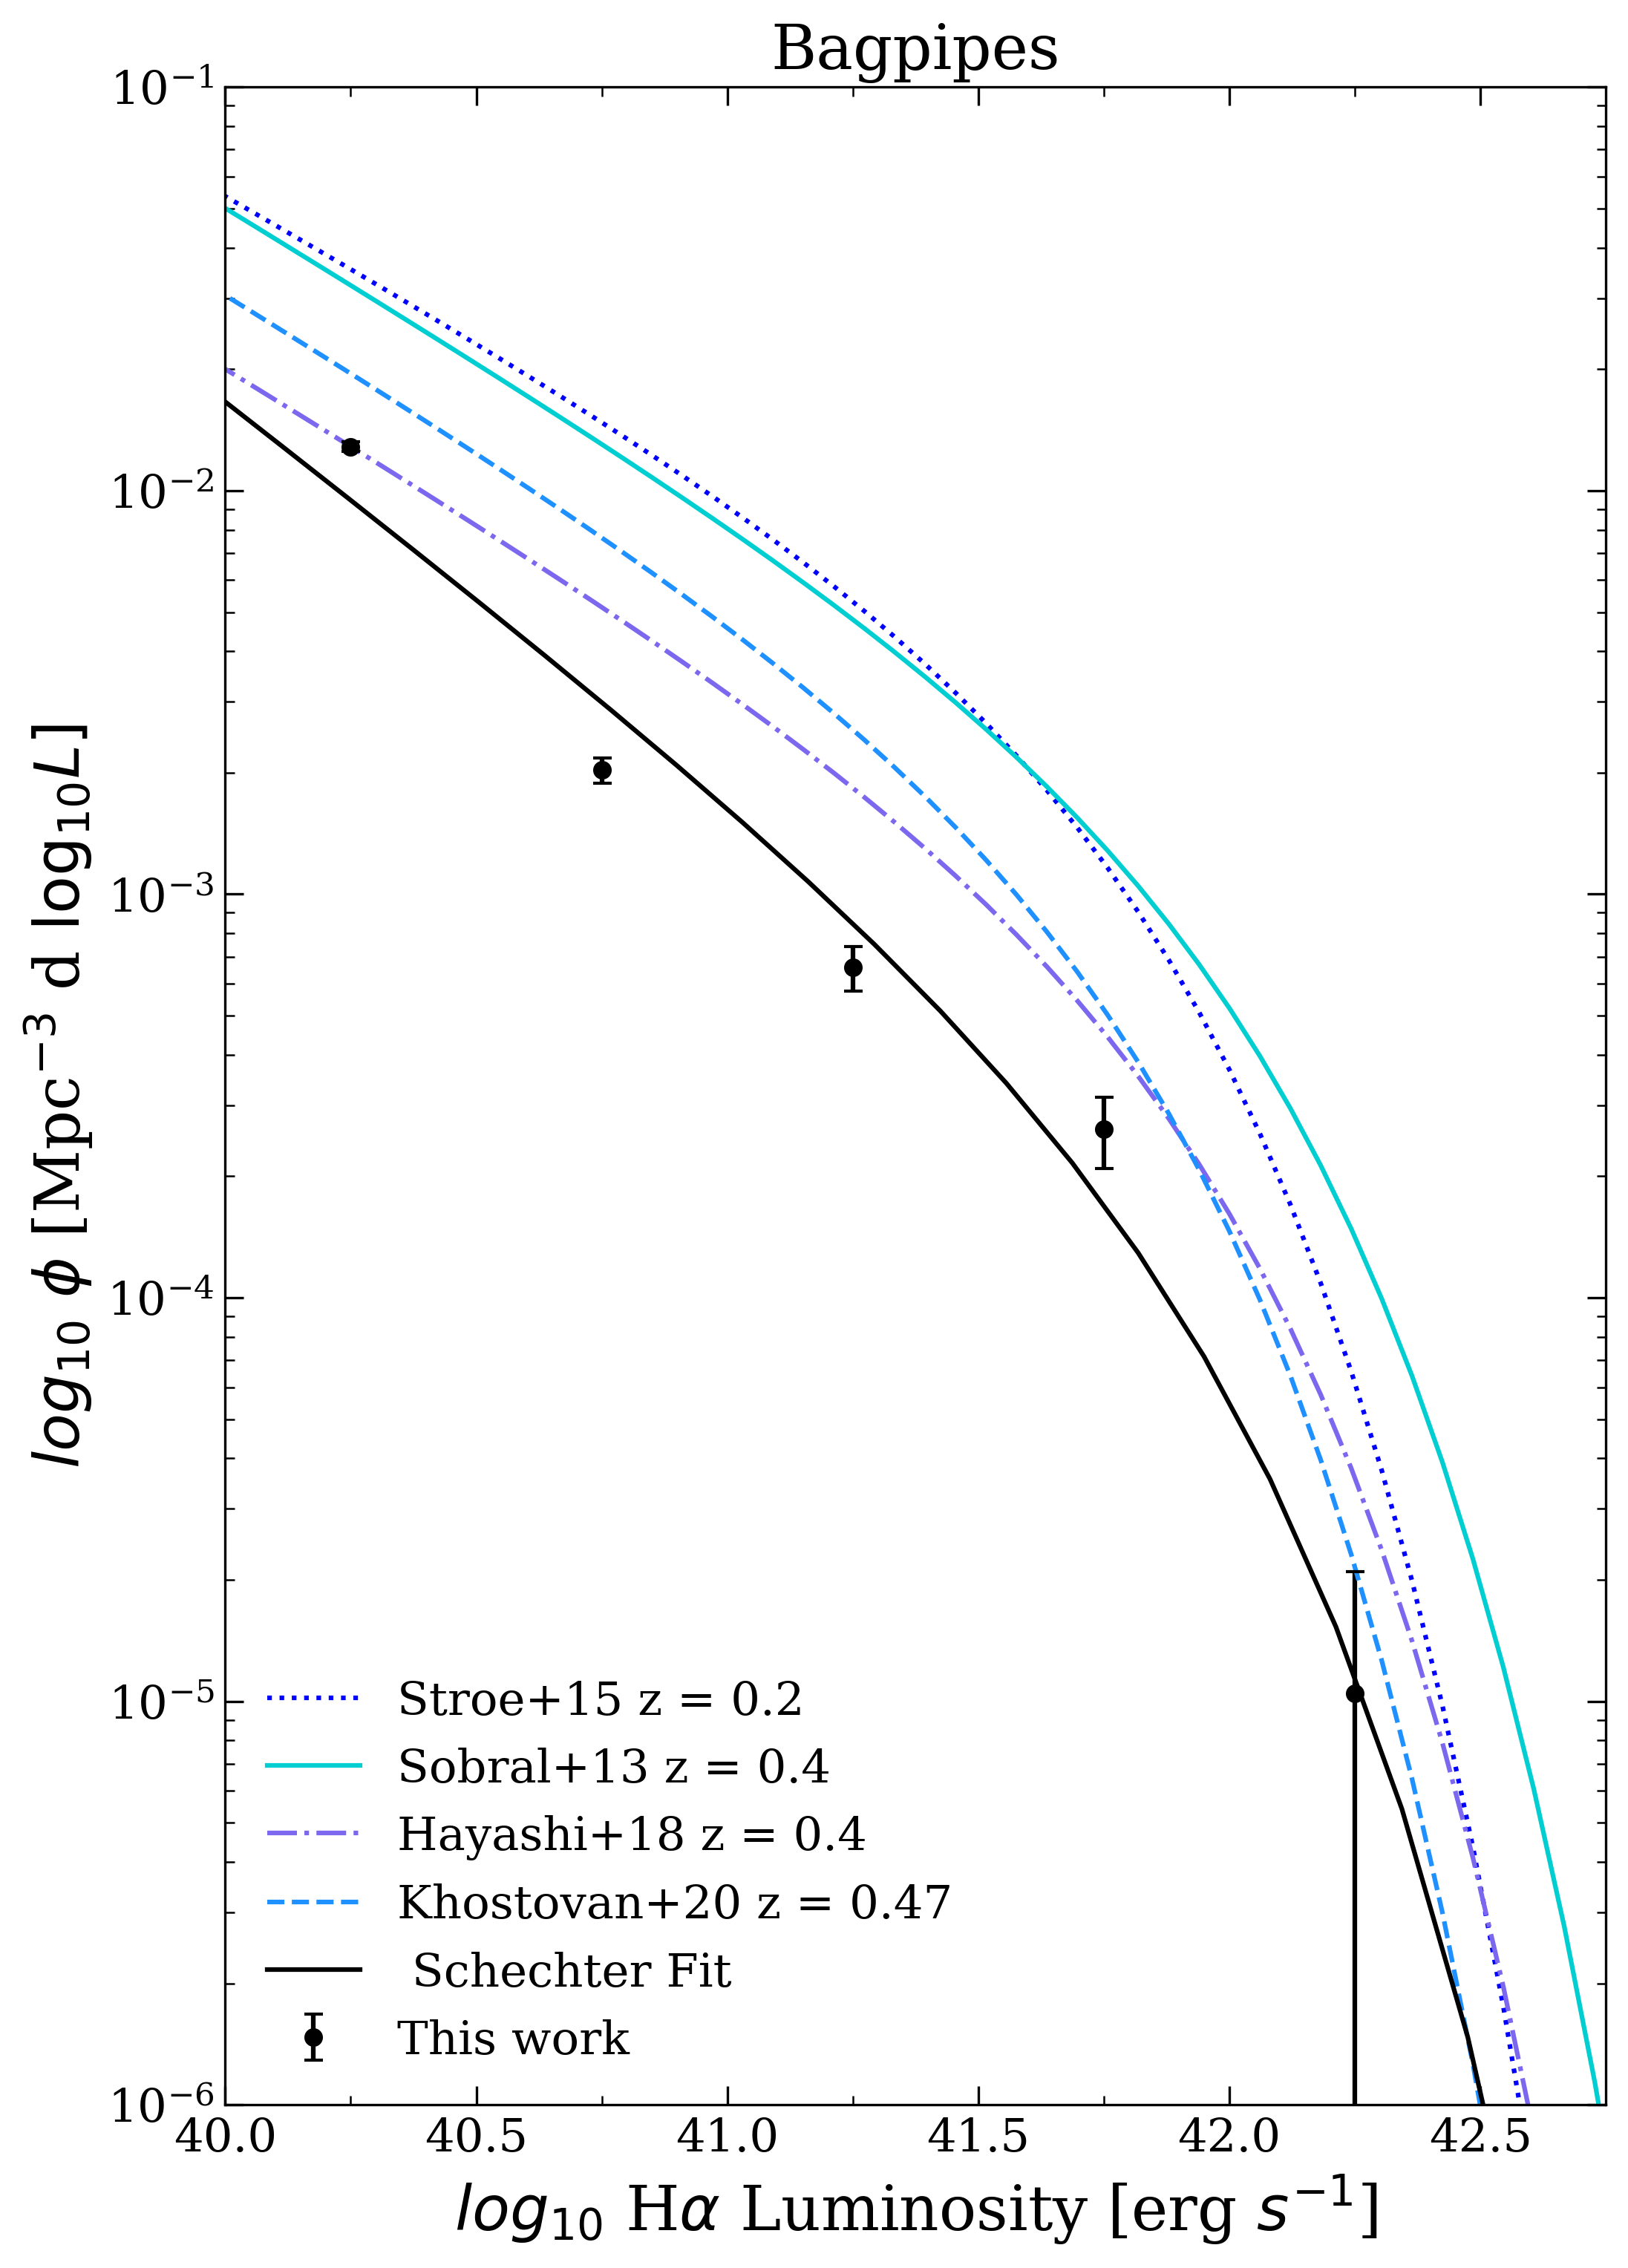

In [97]:
fig, ax = plt.subplots(figsize=(8,12), dpi = 300)

#ax.fill_between(lss_H, phi_max_H, phi_min_H, alpha = 0.1, color = 'blue', label = '$1\sigma$')

ax.plot(lss_H, phi_SS, color = 'blue',  ls = ':',label = 'Stroe+15 z = 0.2')
#ax.plot(lss_H, phi_Ly, color = 'darkturquoise',label = 'Ly+07 z = 0.4')
ax.plot(lss_H, phi_SO, color = 'darkturquoise',  ls = '-',label = 'Sobral+13 z = 0.4')
ax.plot(lss_H, phi_Ha, color = 'mediumslateblue',  ls = '-.',label = 'Hayashi+18 z = 0.4')
ax.plot(lss_H, phia, color = 'dodgerblue',  ls = '--',label = 'Khostovan+20 z = 0.47')
ax.errorbar(bx_H,yy_H, yerr = yy_H*err_H, ls = 'none', marker = 'o',ms =5, color = 'k',capsize = 3, label = 'This work')
ax.plot(x_new, 10**y_new, label=' Schechter Fit', color = 'k')
# ax.plot(lss_H, phi_LyHa, color = 'deepskyblue', label = 'Hayashi+2016 z = 0.4', ls = ':')
# ax.plot(lss_H, phi_LyH, color = 'darkviolet', label = 'Ly+2007 z = 0.4', ls = '--')

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))      # Ticks principales cada 1 unidades en el eje x
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))    # Ticks secundarios cada 0.1 unidades en el eje x
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))      # Ticks principales cada 1 unidades en el eje y
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))    # Ticks secundarios cada 0.5 unidades en el eje y
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', length=6)   # Ticks en el eje x en la parte inferior y superior
ax.tick_params(axis='x', which='minor', bottom=True, top=True, direction='in', length=3)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', length=6)   # Ticks en el eje y en el lado izquierdo y derecho
ax.tick_params(axis='y', which='minor', left=True, right=True, direction='in', length=3)

plt.yscale('log')
plt.ylim(1e-6,1e-1)
plt.xlim(40,42.75)

plt.title('Bagpipes', size = 20)
plt.xlabel(r'$log_{10}$ H$\alpha$ Luminosity [erg $s^{-1}$]')
plt.ylabel(r'$log_{10}$ $\phi$ [Mpc$^{-3}$ d $\log_{10} L]$')
plt.legend(loc =3, frameon=False)
plt.show()

# [OIII]

In [29]:
# mask_2 =  (0.93-bh < data_b['redshift_50']) & (data_b['redshift_50'] < 0.93+bh)
# #mask2 = (0.7 < table['Z_BEST'] ) & (table['Z_BEST'] < 1.1)
# O_III = data_b[mask_2]

mask_2 =  (0.7 < table['redshift_50']) & (table['redshift_50'] < 1.3)

O_III = table[mask_2]
print(len(O_III))

723


In [30]:
phi_star2 = 10**(-2.16) #* (u.Mpc ** -3)
L_star2 = 10**(41.38)
alpha2 = -1.60

In [31]:
OIII_mag = np.array([O_III['MAG_APER_1'][i][aper] for i in range(len(O_III))])

l_OIII = flux_lum(0.93, OIII_mag)

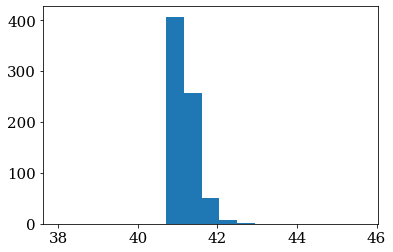

In [32]:
b2 = np.arange(38, 46,0.45)
alf_OIII, blf, clf =plt.hist(l_OIII[0], bins =b2) #alf = objetos por bin
#plt.xlim(41,43.5)
plt.show()

In [33]:
bx_OIII = (b2[0:-1]+b2[1:])/2

binsize_OIII = bx_OIII[1]-bx_OIII[0]

lss_OIII = np.linspace(38,44,100)

In [34]:
vol_OIII = volume_redshift(0.93,2.94)

numb_ =  np.logspace((38),(44),100)
phib = sch(phi_star2, numb_, L_star2, alpha2)

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


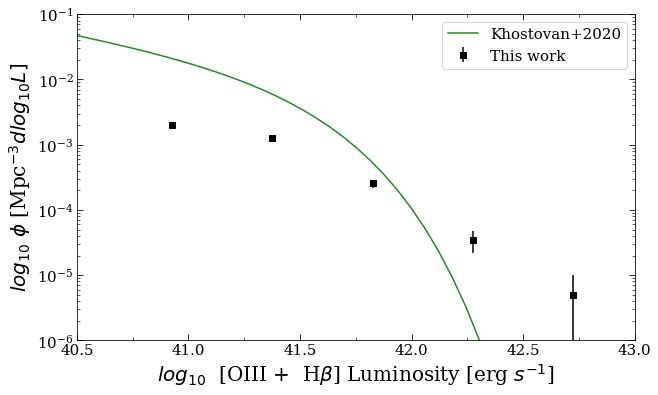

In [35]:
yy_OIII = alf_OIII/vol_OIII/binsize_OIII
err_OIII = 1/np.sqrt(alf_OIII)

fig, ax = plt.subplots(figsize = (10,6))

ax.errorbar(bx_OIII,yy_OIII,yerr = yy_OIII*err_OIII, ls = 'none', marker = 's', color = 'k' , label = 'This work' )
#plt.fill_between(lss_OIII, phi_min_OIII, phi_max_OIII, alpha = 0.1, color = 'forestgreen')
ax.plot(lss_OIII, phib, color = 'forestgreen', label = 'Khostovan+2020')
ax.set_yscale('log')
ax.set_ylim(1e-6,1e-1)
ax.set_xlim(40.5,42.5)



ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))      # Ticks principales cada 1 unidades en el eje x
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))    # Ticks secundarios cada 0.1 unidades en el eje x
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))      # Ticks principales cada 1 unidades en el eje y
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))    # Ticks secundarios cada 0.5 unidades en el eje y
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', length=6)   # Ticks en el eje x en la parte inferior y superior
ax.tick_params(axis='x', which='minor', bottom=True, top=True, direction='in', length=3)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', length=6)   # Ticks en el eje y en el lado izquierdo y derecho
ax.tick_params(axis='y', which='minor', left=True, right=True, direction='in', length=3)

plt.yscale('log')
plt.ylim(1e-6,1e-1)
plt.xlim(40.5,43)

plt.xlabel(r'$log_{10}$  [OIII +  H$\beta$] Luminosity [erg $s^{-1}$]')
plt.ylabel(r'$log_{10}$ $\phi$ [Mpc$^{-3} dlog_{10} L]$')
plt.legend()
plt.show()

In [36]:
mask2 = yy_OIII > 0
yy_OIII2 = yy_OIII[mask2]
bx_OIII2 = bx_OIII[mask2]
err_OIII2 = err_OIII[mask2]

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


Model: schechter2
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
             phis                    Ls                  alpha       
    ---------------------- ---------------------- -------------------
    2.7299074724741386e-05 2.7725646031588332e+42 -2.0865153131532277


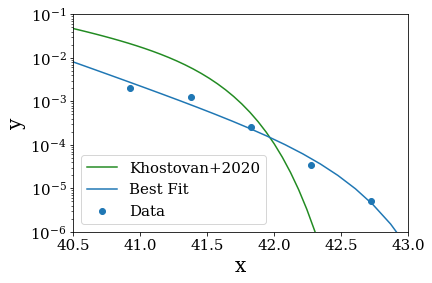

In [116]:
@custom_model
def schechter2(L, phis = phi_star2, Ls = L_star2, alpha = alpha2):
    phi = phis * np.log(10) * (L/Ls)**(1+alpha)*np.exp(-L/Ls)
    return np.log10(phi)


model2 = schechter2()
fitter2 = fitting.LevMarLSQFitter()
best_fit_OIII = fitter2(model2, 10**bx_OIII2, np.log10(yy_OIII2))
print(best_fit_OIII)

x_new = np.linspace(30, 43, 100)
y_new2 = best_fit_OIII(10**x_new)
plt.plot(lss_OIII, phib, color = 'forestgreen', label = 'Khostovan+2020')
plt.scatter(bx_OIII2, yy_OIII2, label='Data')
plt.plot(x_new, 10**y_new2, label='Best Fit')
plt.legend()
plt.yscale('log')
plt.xlim(40.5,43)
plt.ylim(1e-6,1e-1)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value 

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value 

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value 

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3

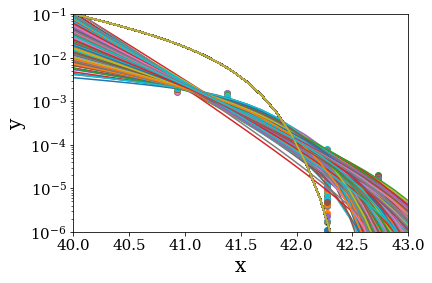

CPU times: user 1min 37s, sys: 4.53 s, total: 1min 42s
Wall time: 1min 35s


In [38]:
%%time
results2 = []
iterations = 2000
while len(results2) < iterations:
    values_y = []
    for i, bins in enumerate(yy_OIII2): 
        s = np.random.normal(bins, bins*err_OIII2[i],1)
        values_y.append(s[0])
        
    
    values_y = np.array(values_y)

    model2 = schechter2()
    fitter2 = fitting.LevMarLSQFitter()
    best_fit2 = fitter2(model2, 10**bx_OIII2, np.log10(values_y))
    results2.append((best_fit2.phis.value, best_fit2.Ls.value, best_fit2.alpha.value))
    
    x_new = np.linspace(30, 43, 100)
    y_new2 = best_fit2(10**x_new)
    plt.scatter(bx_OIII2, values_y)
    plt.plot(x_new, 10**y_new2)
    plt.yscale('log')
    plt.xlim(40,43)
    plt.ylim(1e-6,1e-1)
    plt.xlabel('x')
    plt.ylabel('y')
plt.show()

results2 = np.array(results2)

In [39]:
res_phi2 = np.array([results2[i][0] for i in range(len(results2))])
res_Ls2 = np.array([results2[i][1] for i in range(len(results2))])
res_alpha2 = np.array([results2[i][2] for i in range(len(results2))])

phi_scs2 =sigma_clipped_stats(res_phi2)
Ls_scs2 = sigma_clipped_stats(res_Ls2)
alpha_scs2 = sigma_clipped_stats(res_alpha2)

phisH2 = (best_fit2.phis.value)
errphil2 =((phi_scs2[1]-7e-5))
errphih2 = ((phi_scs2[1]+phi_scs2[2]))

LsH2 =((best_fit2.Ls.value))
errLsl2 =((Ls_scs2[1]+Ls_scs2[2]))
errLsh2 =((Ls_scs2[1]-Ls_scs2[2]))

# alphaH =(best_fit_mH.alpha.value)
# erralphah = ((alpha_scs[1]-alpha_scs[2]))
# erralphal =((alpha_scs[1]+alpha_scs[2]))

In [40]:
print('Erros for Phi:')
print(np.log10(best_fit_OIII.phis.value))
print(np.log10(phi_scs2[1])-np.log10(phi_scs2[1]+phi_scs2[2]))
print(np.log10(phi_scs2[1])-np.log10(phi_scs2[1]-phi_scs2[2]))
print('Erros for Ls:')
print(np.log10(best_fit_OIII.Ls.value))
print(np.log10(Ls_scs2[1])-np.log10(Ls_scs2[1]-Ls_scs2[2]))
print(np.log10(Ls_scs2[1])-np.log10(Ls_scs2[1]+Ls_scs2[2]))
print('Erros for alpha:')
print(best_fit_OIII.alpha.value)
print((alpha_scs2[1])-(alpha_scs2[1]-alpha_scs2[2]))
print((alpha_scs2[1])-(alpha_scs2[1]+alpha_scs2[2]))

Erros for Phi:
-4.563852072693639
-1.9863141634939714
nan
Erros for Ls:
42.44288167437702
1.1022265417897827
-0.2835213445516871
Erros for alpha:
-2.0865153131532277
0.244290223020307
-0.244290223020307


/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


In [98]:
#STROE SOBRAL HA z = 2
#phi_SS2 = sch(10**(-2.85), numb_, 10**(41.75),-1.7)
#HAYASHI 2018
phi_Ha2 = sch(10**(-3.71), numb_, 10**(42.17), -1.95)
#LY 2007
phi_Ly2 = sch(10**(-2.54), numb_, 10**(41.53), -1.22)
#Khostovan Z = 0.84
phi_K2 = sch(10**(-2.55), numb_, 10**(41.79),-1.6)

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


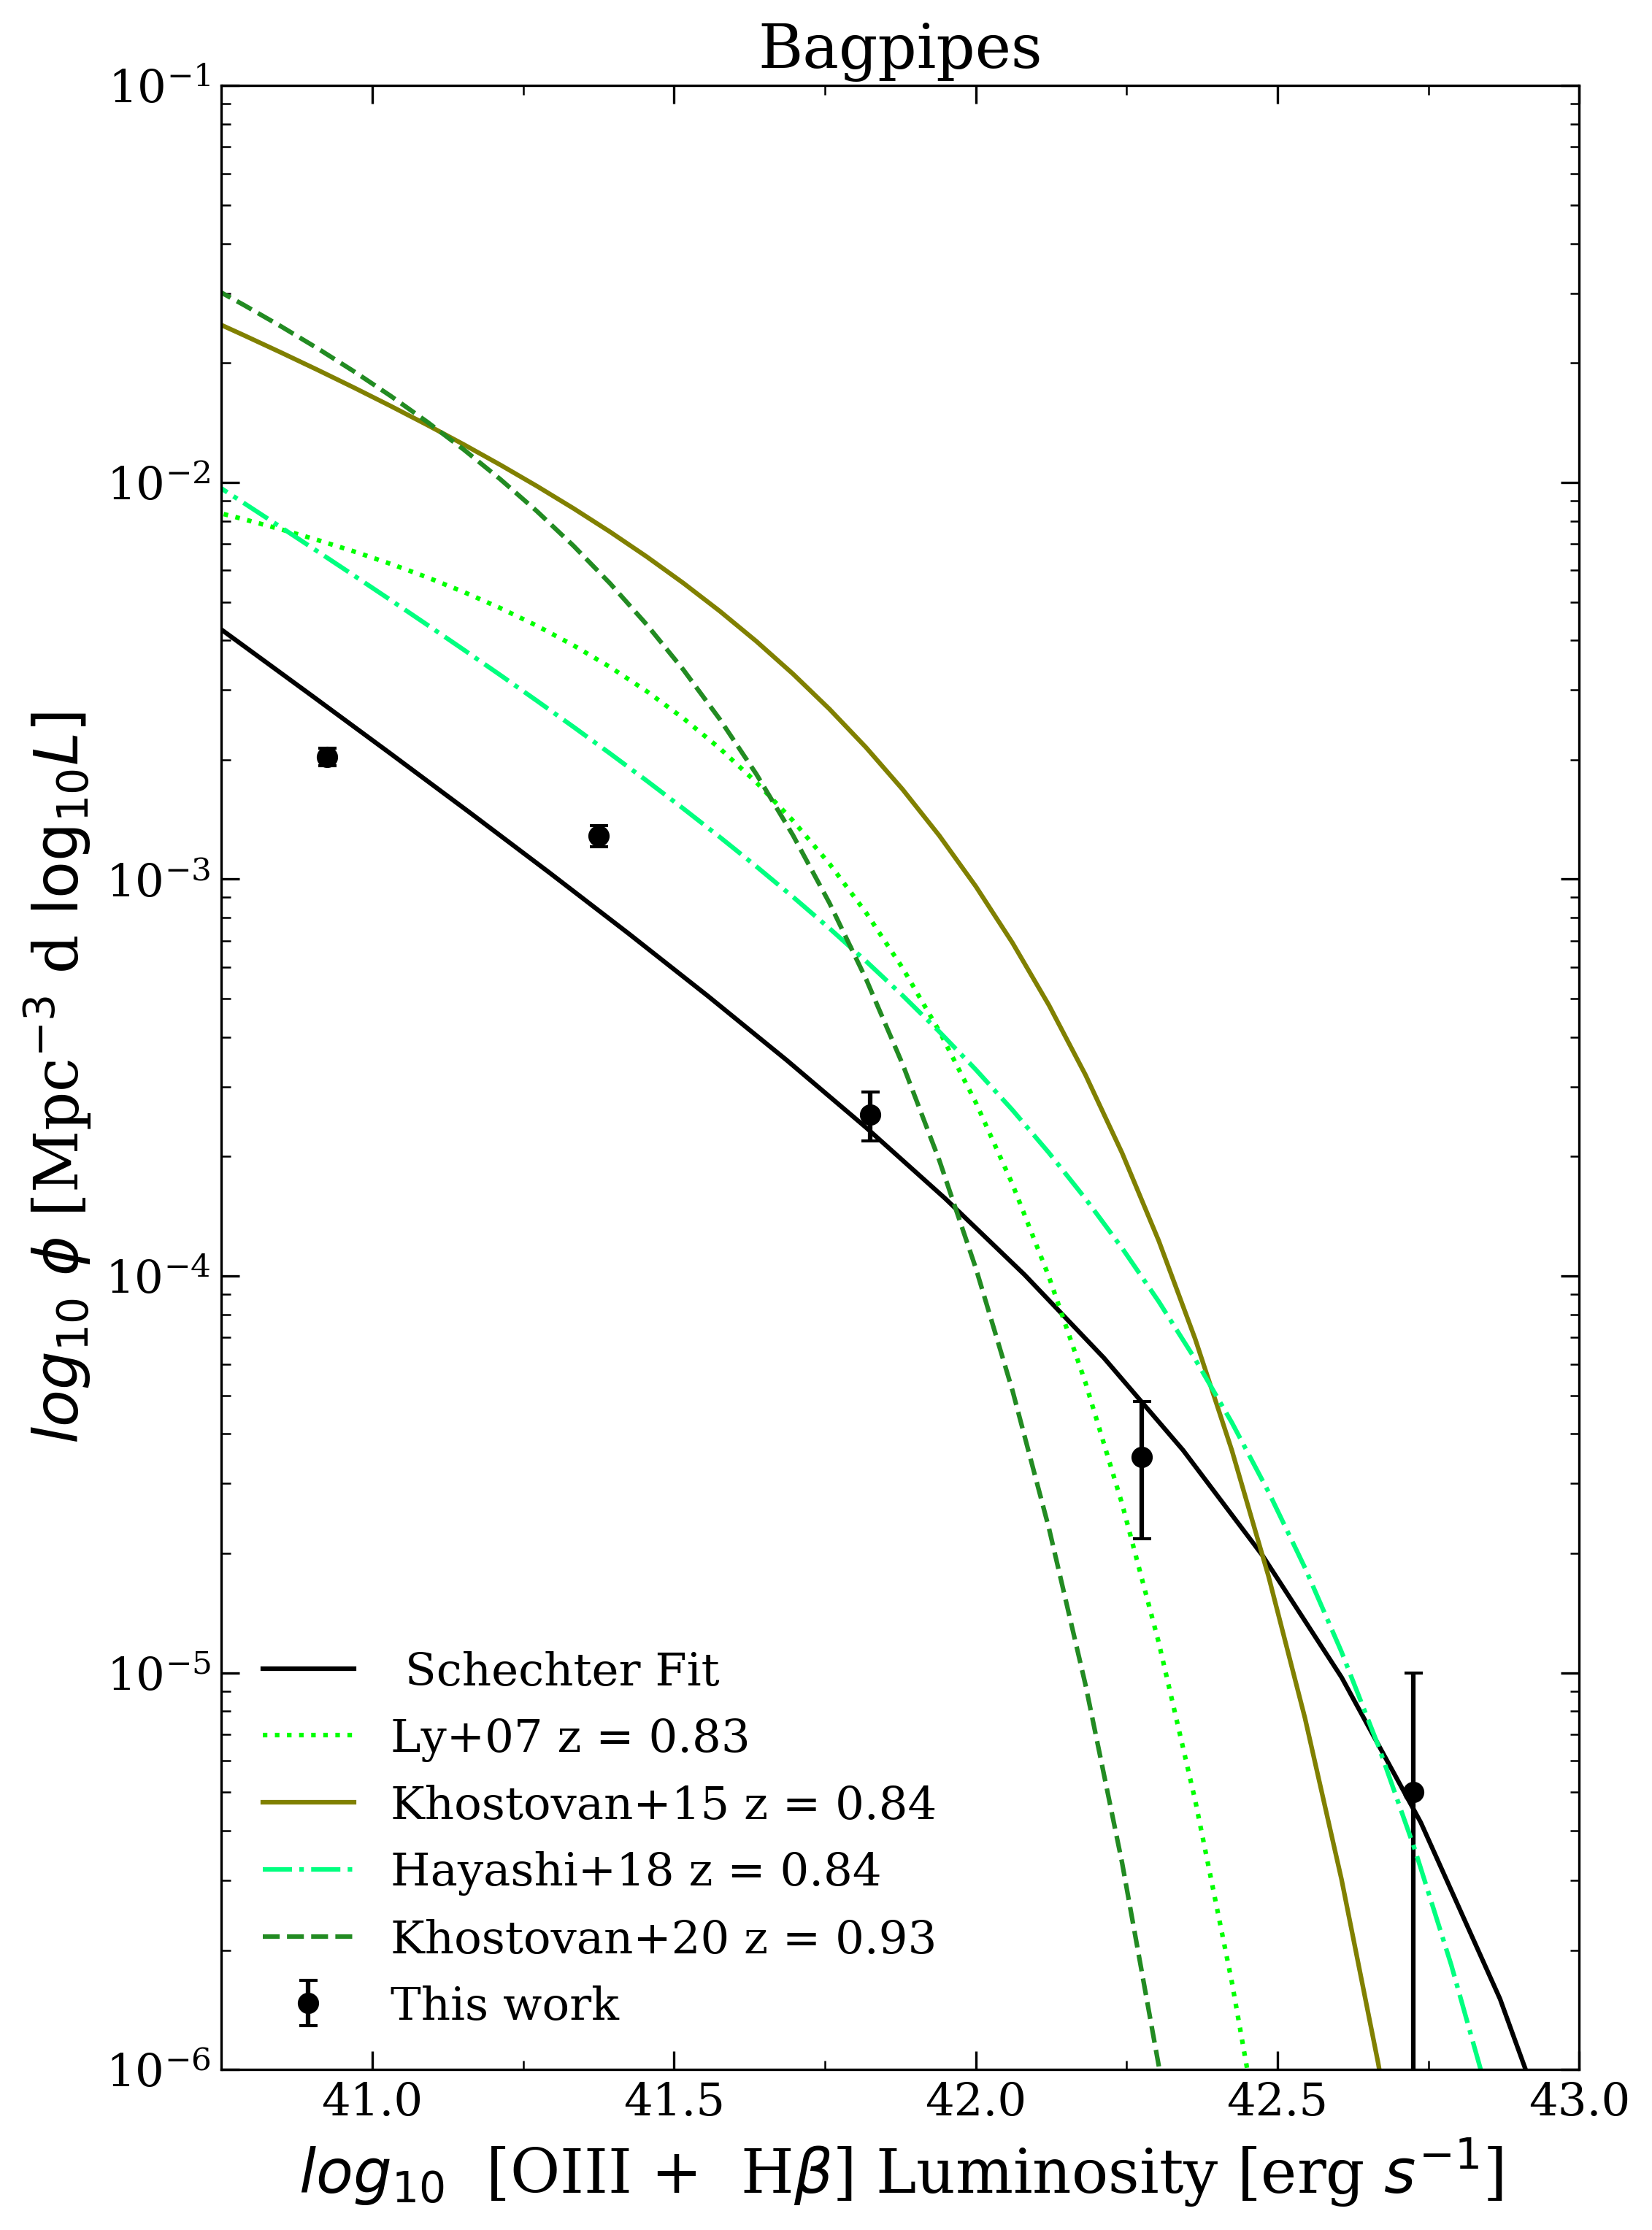

In [117]:
fig, ax = plt.subplots(figsize=(8,12), dpi = 300)

#ax.fill_between(lss_H, phi_min_OIII, phi_max_OIII, alpha = 0.1, color = 'forestgreen', label = '$1\sigma$')

ax.errorbar(bx_OIII,yy_OIII, yerr = yy_OIII*err_OIII, ls = 'none', marker = 'o', color = 'k',capsize = 3, label = 'This work')
ax.plot(x_new, 10**y_new2, label=' Schechter Fit', color = 'k')
ax.plot(lss_H, phi_Ly2, color = 'lime',label = 'Ly+07 z = 0.83', ls = ':')
ax.plot(lss_H, phi_K2, color = 'olive',  ls = '-',label = 'Khostovan+15 z = 0.84')
ax.plot(lss_H, phi_Ha2, color = 'springgreen',  ls = '-.',label = 'Hayashi+18 z = 0.84')
ax.plot(lss_H, phib, color = 'forestgreen',  ls = '--',label = 'Khostovan+20 z = 0.93')
#ax.plot(lss_H, phib, color = 'forestgreen',  ls = '--',label = 'Khostovan+2020')
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))      # Ticks principales cada 1 unidades en el eje x
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))    # Ticks secundarios cada 0.1 unidades en el eje x
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))      # Ticks principales cada 1 unidades en el eje y
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))    # Ticks secundarios cada 0.5 unidades en el eje y
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', length=6)   # Ticks en el eje x en la parte inferior y superior
ax.tick_params(axis='x', which='minor', bottom=True, top=True, direction='in', length=3)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', length=6)   # Ticks en el eje y en el lado izquierdo y derecho
ax.tick_params(axis='y', which='minor', left=True, right=True, direction='in', length=3)

plt.yscale('log')
plt.ylim(1e-6,1e-1)
plt.xlim(40.75,43)

plt.title('Bagpipes', size = 20)
plt.xlabel(r'$log_{10}$  [OIII +  H$\beta$] Luminosity [erg $s^{-1}$]')
plt.ylabel(r'$log_{10}$ $\phi$ [Mpc$^{-3}$ d $\log_{10} L]$')
plt.legend(loc =3, frameon=False)
plt.show()

# [OII]

In [43]:
# mask_3 =  (1.59-ch < data_c['redshift_50']) & (data_c['redshift_50'] < 1.59+cl)
# #mask3 = (1.5 < data_c['redshift_50'] ) & (data_c['redshift_50'] < 1.7)
# O_II = data_c[mask_3]

mask_3 =  (1.3 < table['redshift_50']) & (table['redshift_50'] < 2)
O_II = table[mask_3]

In [44]:
print(1.59+cl)

1.8553277139269122


In [45]:
phi_star3 = 10**(-1.97) 
L_star3 =10**(41.66)
alpha3 = -1.30

In [46]:
OII_mag = np.array([O_II['MAG_APER_1'][i][aper] for i in range(len(O_II))])

l_OII = flux_lum(1.59, OII_mag)

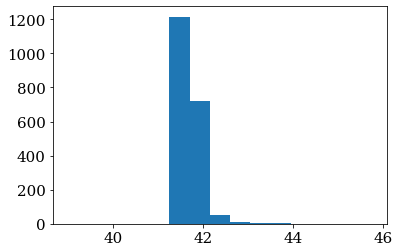

In [47]:
b3 = np.arange(39, 46,0.45)
alf_OII, blf, clf =plt.hist(l_OII[0], bins =b3) #alf = objetos por bin
#plt.xlim(41,43.5)
plt.show()

In [48]:
alf_OII

array([   0.,    0.,    0.,    0.,    0., 1215.,  719.,   53.,   11.,
          4.,    2.,    0.,    0.,    0.,    0.])

In [49]:
bx_OII = (b3[0:-1]+b3[1:])/2

binsize_OII = bx_OII[1]-bx_OII[0]

lss_OII = np.linspace(38,44,100)

In [50]:
vol_OII = volume_redshift(1.59,2.94)

numb_ =  np.logspace((38),(44),100)
phic = sch(phi_star3, numb_, L_star3, alpha3)

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


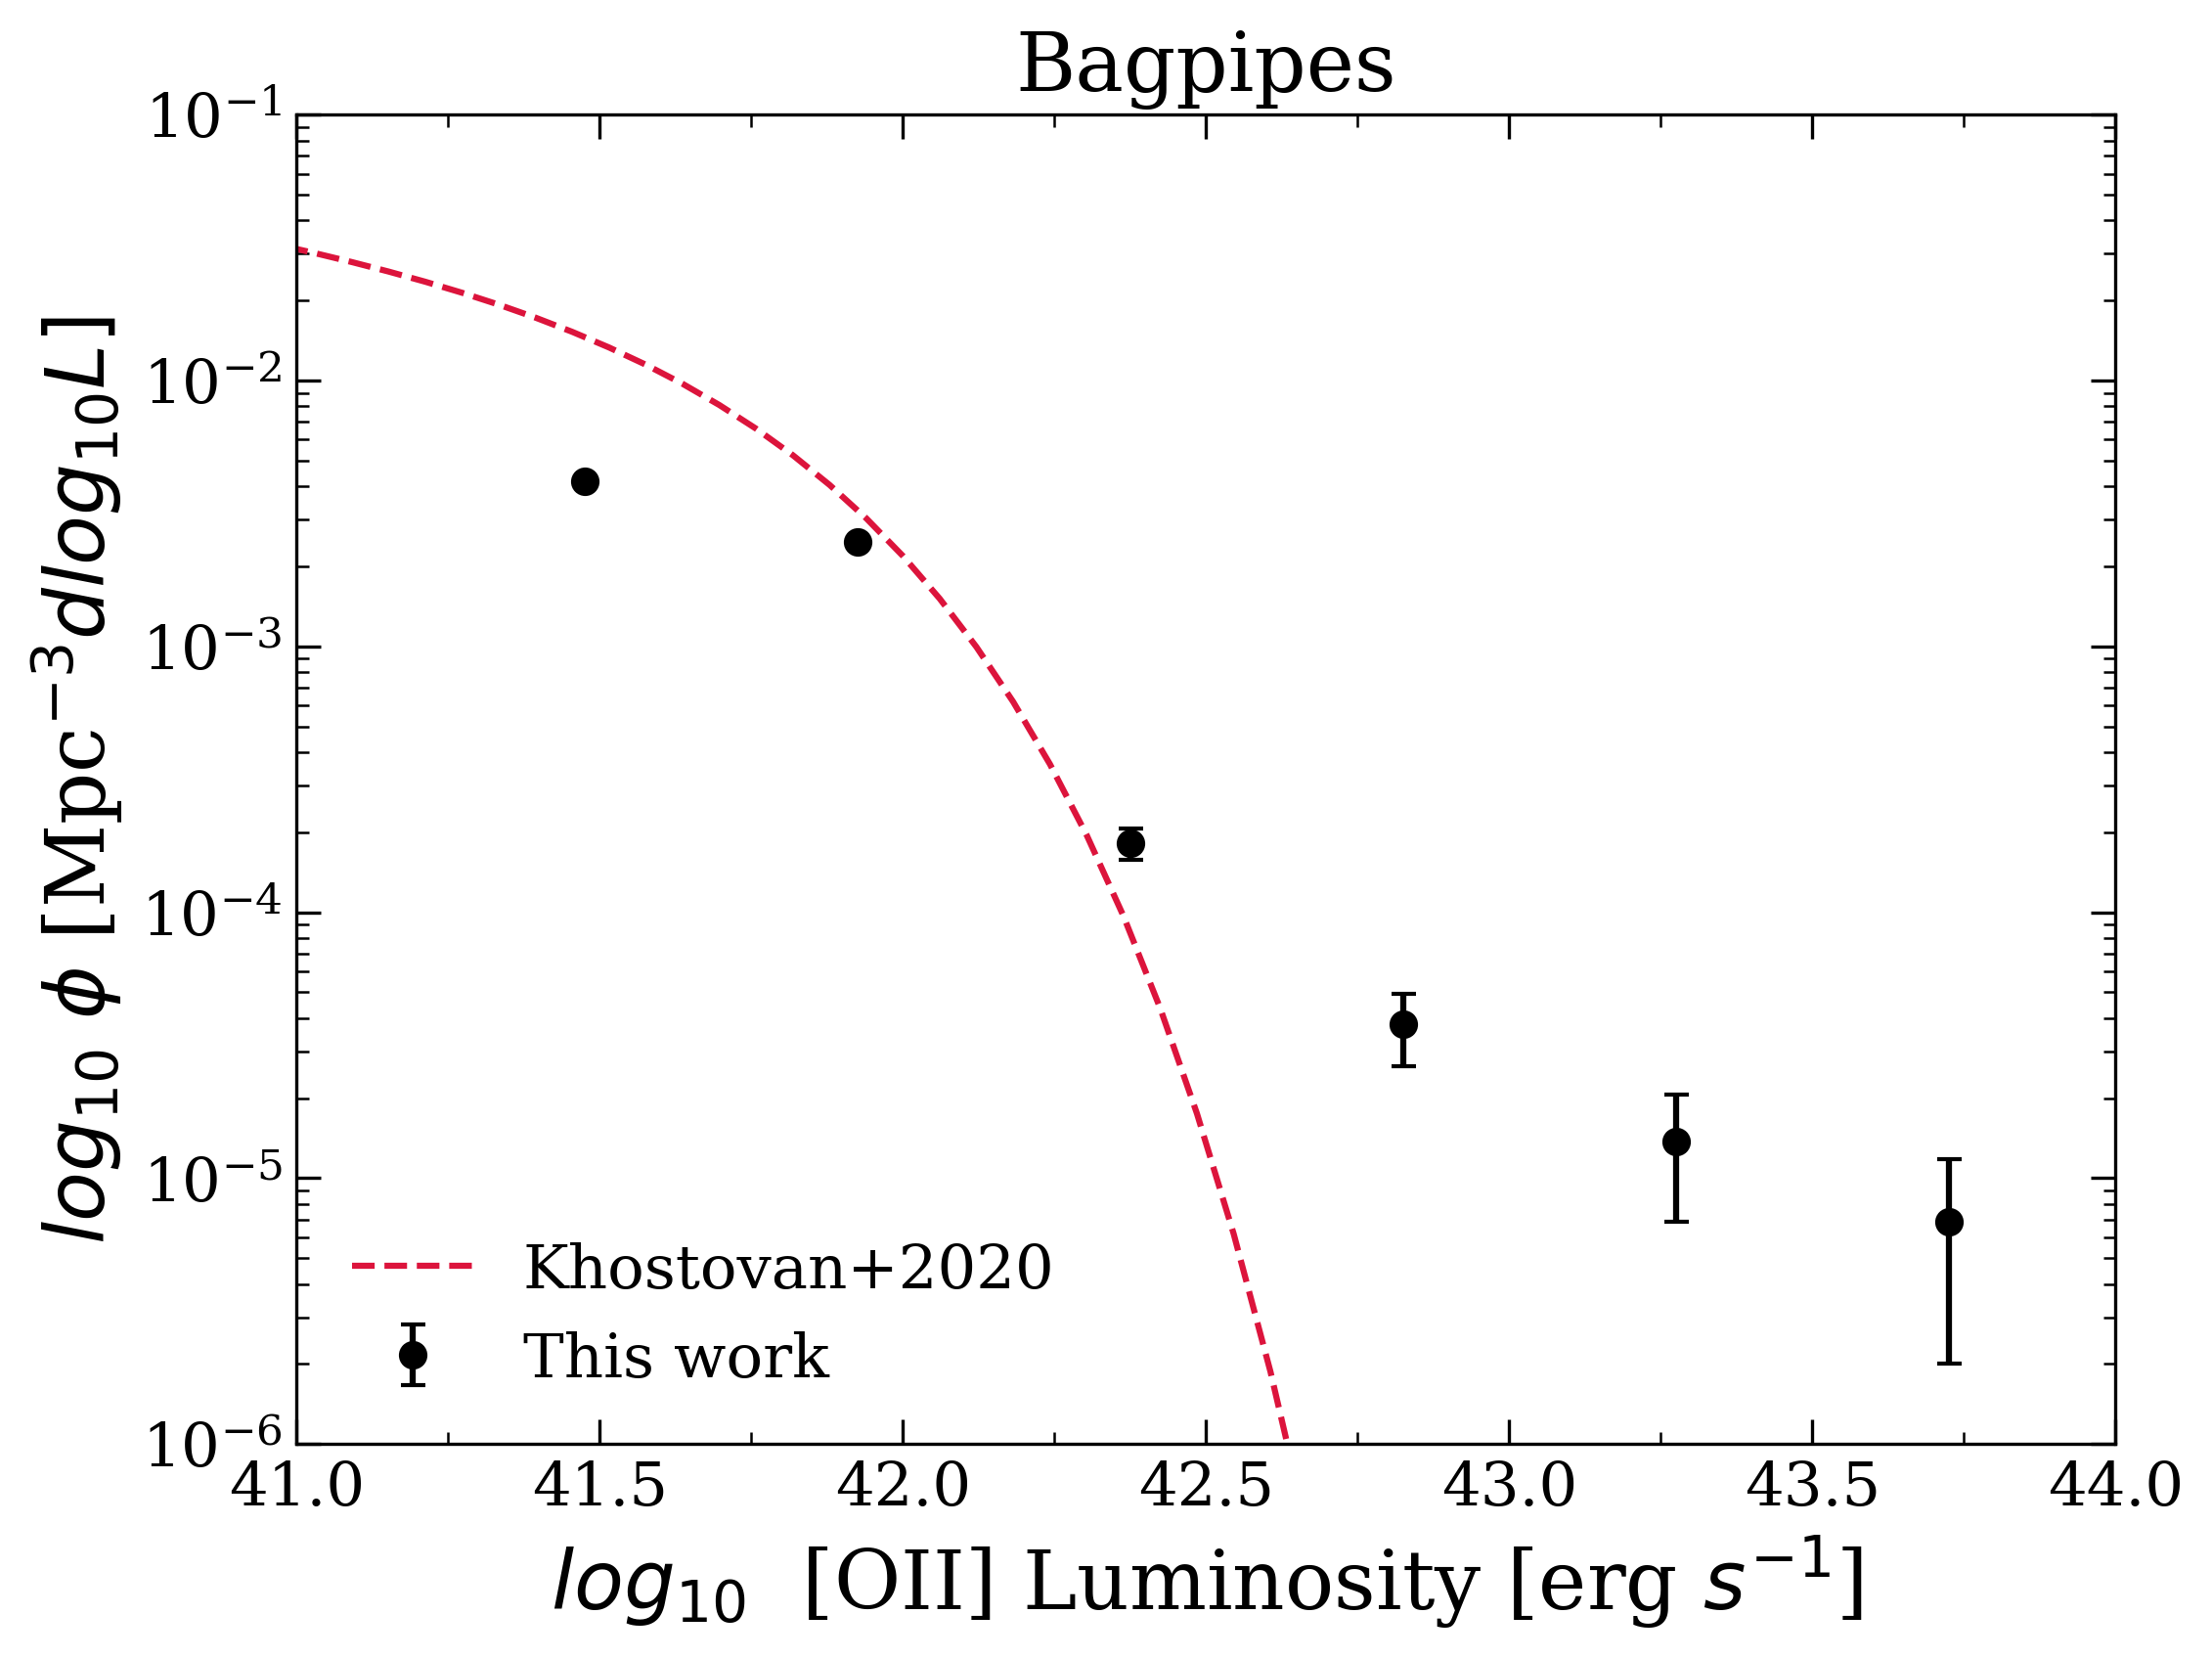

In [51]:
yy_OII = alf_OII/vol_OII/binsize_OII
err_OII = 1/np.sqrt(alf_OII)

fig, ax = plt.subplots(figsize = (8,6), dpi = 300)
ax.errorbar(bx_OII,yy_OII, yerr = yy_OII*err_OII, ls = 'none', marker = 'o', color = 'k',capsize = 3, label = 'This work')
#plt.fill_between(lss_OII, phi_min_OII, phi_max_OII, alpha = 0.1, color = 'crimson')
ax.plot(lss_OII, phic, color = 'crimson', label = 'Khostovan+2020', ls = '--')



ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))      # Ticks principales cada 1 unidades en el eje x
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))    # Ticks secundarios cada 0.1 unidades en el eje x
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))      # Ticks principales cada 1 unidades en el eje y
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))    # Ticks secundarios cada 0.5 unidades en el eje y
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', length=6)   # Ticks en el eje x en la parte inferior y superior
ax.tick_params(axis='x', which='minor', bottom=True, top=True, direction='in', length=3)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', length=6)   # Ticks en el eje y en el lado izquierdo y derecho
ax.tick_params(axis='y', which='minor', left=True, right=True, direction='in', length=3)


plt.yscale('log')
plt.ylim(1e-6,1e-1)
plt.xlim(41,44)
plt.title('Bagpipes', size = 20)
plt.xlabel(r'$log_{10}$  [OII] Luminosity [erg $s^{-1}$]')
plt.ylabel(r'$log_{10}$ $\phi$ [Mpc$^{-3} dlog_{10} L]$')
plt.legend(loc = 3, frameon=False )
plt.show()

In [102]:
mask3 = yy_OII > 0
yy_OII2 = yy_OII[mask3]
bx_OII2 = bx_OII[mask3]
err_OII2 = err_OII[mask3]

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


Model: schechter3
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
             phis                    Ls          
    ---------------------- ----------------------
    2.5079227998695958e-05 2.5727732267255257e+43


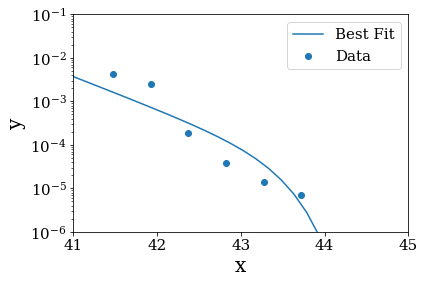

In [108]:
@custom_model
def schechter3(L, phis = phi_star3, Ls = L_star3):
    phi = phis * np.log(10) * (L/Ls)**(1+alpha)*np.exp(-L/Ls)
    return np.log10(phi)


model3 = schechter3()
fitter3 = fitting.LevMarLSQFitter()
best_fit_O2 = fitter3(model3, 10**bx_OII2, np.log10(yy_OII2))
print(best_fit_O2)

x_new = np.linspace(30, 45, 100)
y_new3 = best_fit_O2(10**x_new)
#plt.plot(lss_OII, phic, color = 'forestgreen', label = 'Khostovan+2020')
plt.scatter(bx_OII2, yy_OII2, label='Data')
plt.plot(x_new, 10**y_new3, label='Best Fit')
plt.legend()
plt.yscale('log')
plt.xlim(41,45)
plt.ylim(1e-6,1e-1)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [112]:
#HAYASHI 2018 z = 1.47
phi_Ha3 = sch(10**(-2.88), numb_, 10**(42.10), -1.83)
#LY 2007 z = 1.47
phi_Ly3 = sch(10**(-1.97), numb_, 10**(41.60), -0.78)
#Khostovan Z = 1.47
phi_K3 = sch(10**(-2.25), numb_, 10**(41.89),-1.3)

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


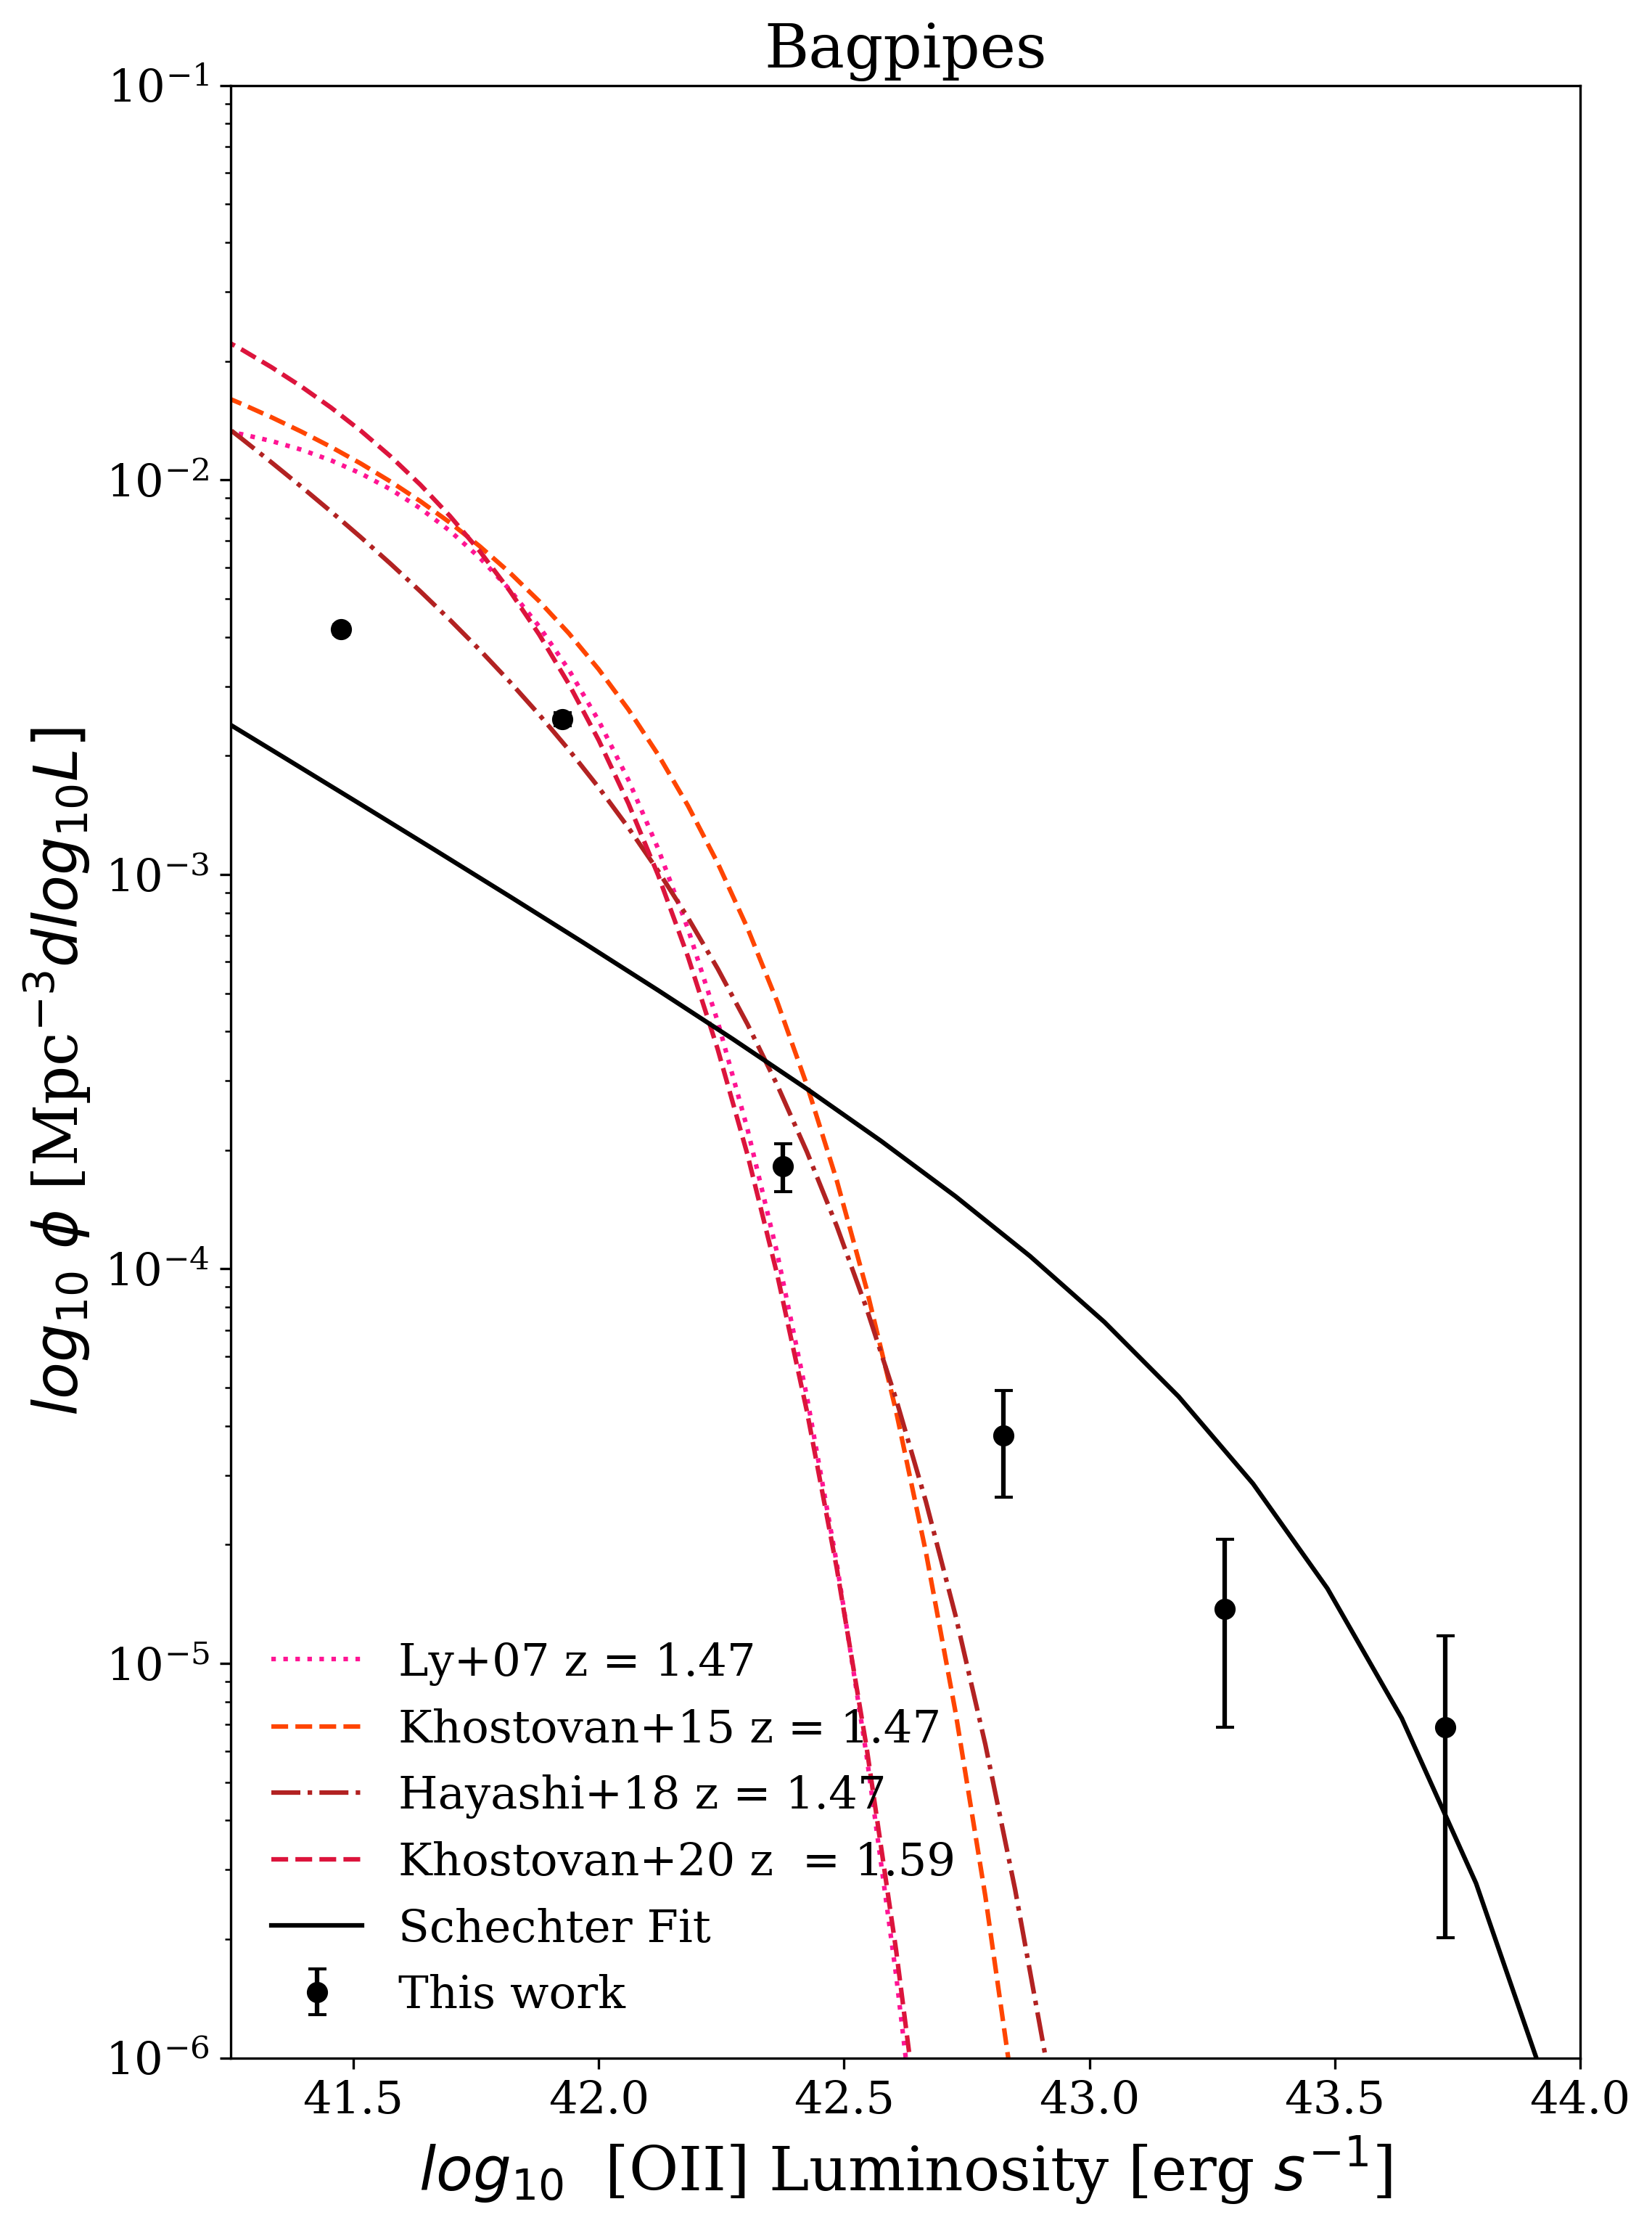

In [114]:
fig, ax = plt.subplots(figsize = (8,12), dpi = 300)
ax.errorbar(bx_OII,yy_OII, yerr = yy_OII*err_OII, ls = 'none', marker = 'o', color = 'k',capsize = 3, label = 'This work')
ax.plot(lss_H, phi_Ly3, color = 'deeppink',label = 'Ly+07 z = 1.47', ls = ':')
#ax.plot(lss_H, phi_SO2, color = 'darkturquoise',  ls = '-',label = 'Sobral+15 z = 0.84')
ax.plot(lss_H, phi_K3, color = 'orangered',  ls = '--',label = 'Khostovan+15 z = 1.47')
ax.plot(lss_H, phi_Ha3, color = 'firebrick',  ls = '-.',label = 'Hayashi+18 z = 1.47')
#ax.plot(lss_H, phib, color = 'forestgreen',  ls = '--',label = 'Khostovan+15 z = 1.47')
plt.plot(lss_OII, phic, color = 'crimson', label = 'Khostovan+20 z  = 1.59', ls = '--')
plt.plot(x_new, 10**y_new3, label='Schechter Fit', color = 'k')
plt.yscale('log')
plt.ylim(1e-6,1e-1)
plt.xlim(41.25,44)

plt.title('Bagpipes', size = 20)
plt.xlabel(r'$log_{10}$  [OII] Luminosity [erg $s^{-1}$]')
plt.ylabel(r'$log_{10}$ $\phi$ [Mpc$^{-3} dlog_{10} L]$')
plt.legend(loc = 3, frameon=False)
plt.show()

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launche

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launche

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3

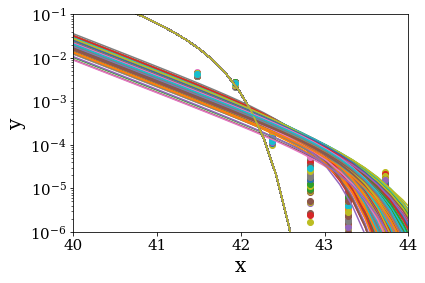

CPU times: user 55.9 s, sys: 2.47 s, total: 58.4 s
Wall time: 53.9 s


In [105]:
%%time
results3 = []
iterations = 2000
while len(results3) < iterations:
    values_y = []
    for i, bins in enumerate(yy_OII2): 
        s = np.random.normal(bins, bins*err_OII2[i],1)
        values_y.append(s[0])
        
    
    values_y = np.array(values_y)

    model3 = schechter3()
    fitter3 = fitting.LevMarLSQFitter()
    best_fit3 = fitter3(model3, 10**bx_OII2, np.log10(values_y))
    results3.append((best_fit3.phis.value, best_fit3.Ls.value))
    
    x_new = np.linspace(30, 45, 100)
    y_new3 = best_fit3(10**x_new)
    plt.scatter(bx_OII2, values_y)
    plt.plot(x_new, 10**y_new3)
    plt.yscale('log')
    plt.xlim(40,44)
    plt.ylim(1e-6,1e-1)
    plt.xlabel('x')
    plt.ylabel('y')
plt.show()

results3 = np.array(results3)

In [106]:
res_phi3 = np.array([results3[i][0] for i in range(len(results3))])
res_Ls3 = np.array([results3[i][1] for i in range(len(results3))])
#res_alpha3 = np.array([results3[i][2] for i in range(len(results3))])

phi_scs3 =sigma_clipped_stats(res_phi3)
Ls_scs3 = sigma_clipped_stats(res_Ls3)
#alpha_scs3 = sigma_clipped_stats(res_alpha3)

In [107]:
print('Erros for Phi:')
print(np.log10(best_fit_O2.phis.value))
print(np.log10(phi_scs3[1])-np.log10(phi_scs3[1]-phi_scs3[2]))
print(np.log10(phi_scs3[1])-np.log10(phi_scs3[1]+phi_scs3[2]))
print('Erros for Ls:')
print(np.log10(best_fit_O2.Ls.value))
print(np.log10(Ls_scs3[1])-np.log10(Ls_scs3[1]-Ls_scs3[2]))
print(np.log10(Ls_scs3[1])-np.log10(Ls_scs3[1]+Ls_scs3[2]))
# print('Erros for alpha:')
# print(best_fit_O2.alpha.value)
# print((alpha_scs3[1])-(alpha_scs3[1]-alpha_scs3[2]))
# print((alpha_scs3[1])-(alpha_scs3[1]+alpha_scs3[2]))

Erros for Phi:
-4.600685836304903
0.15010310926367776
-0.11133722290368109
Erros for Ls:
43.410401507655315
0.2526861791782622
-0.15870198650030432
